In [223]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, \
                                            QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import os

In [224]:
# csv_path = "~/Documents/stat_learning/csv_files"
# Auto = pd.read_csv(os.path.join(csv_path, "Auto.data"), 
#                     na_values = ["?"], 
#                     sep="\s+")
Auto = load_data("Auto")
Auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,27.0,4,140.0,86,2790,15.6,82,1
vw pickup,44.0,4,97.0,52,2130,24.6,82,2
dodge rampage,32.0,4,135.0,84,2295,11.6,82,1


In [225]:
mpg01 = np.where(Auto.mpg >= Auto.mpg.median(), 1, 0)
Auto["mpg01"] = mpg01
Auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin', 'mpg01'],
      dtype='object')

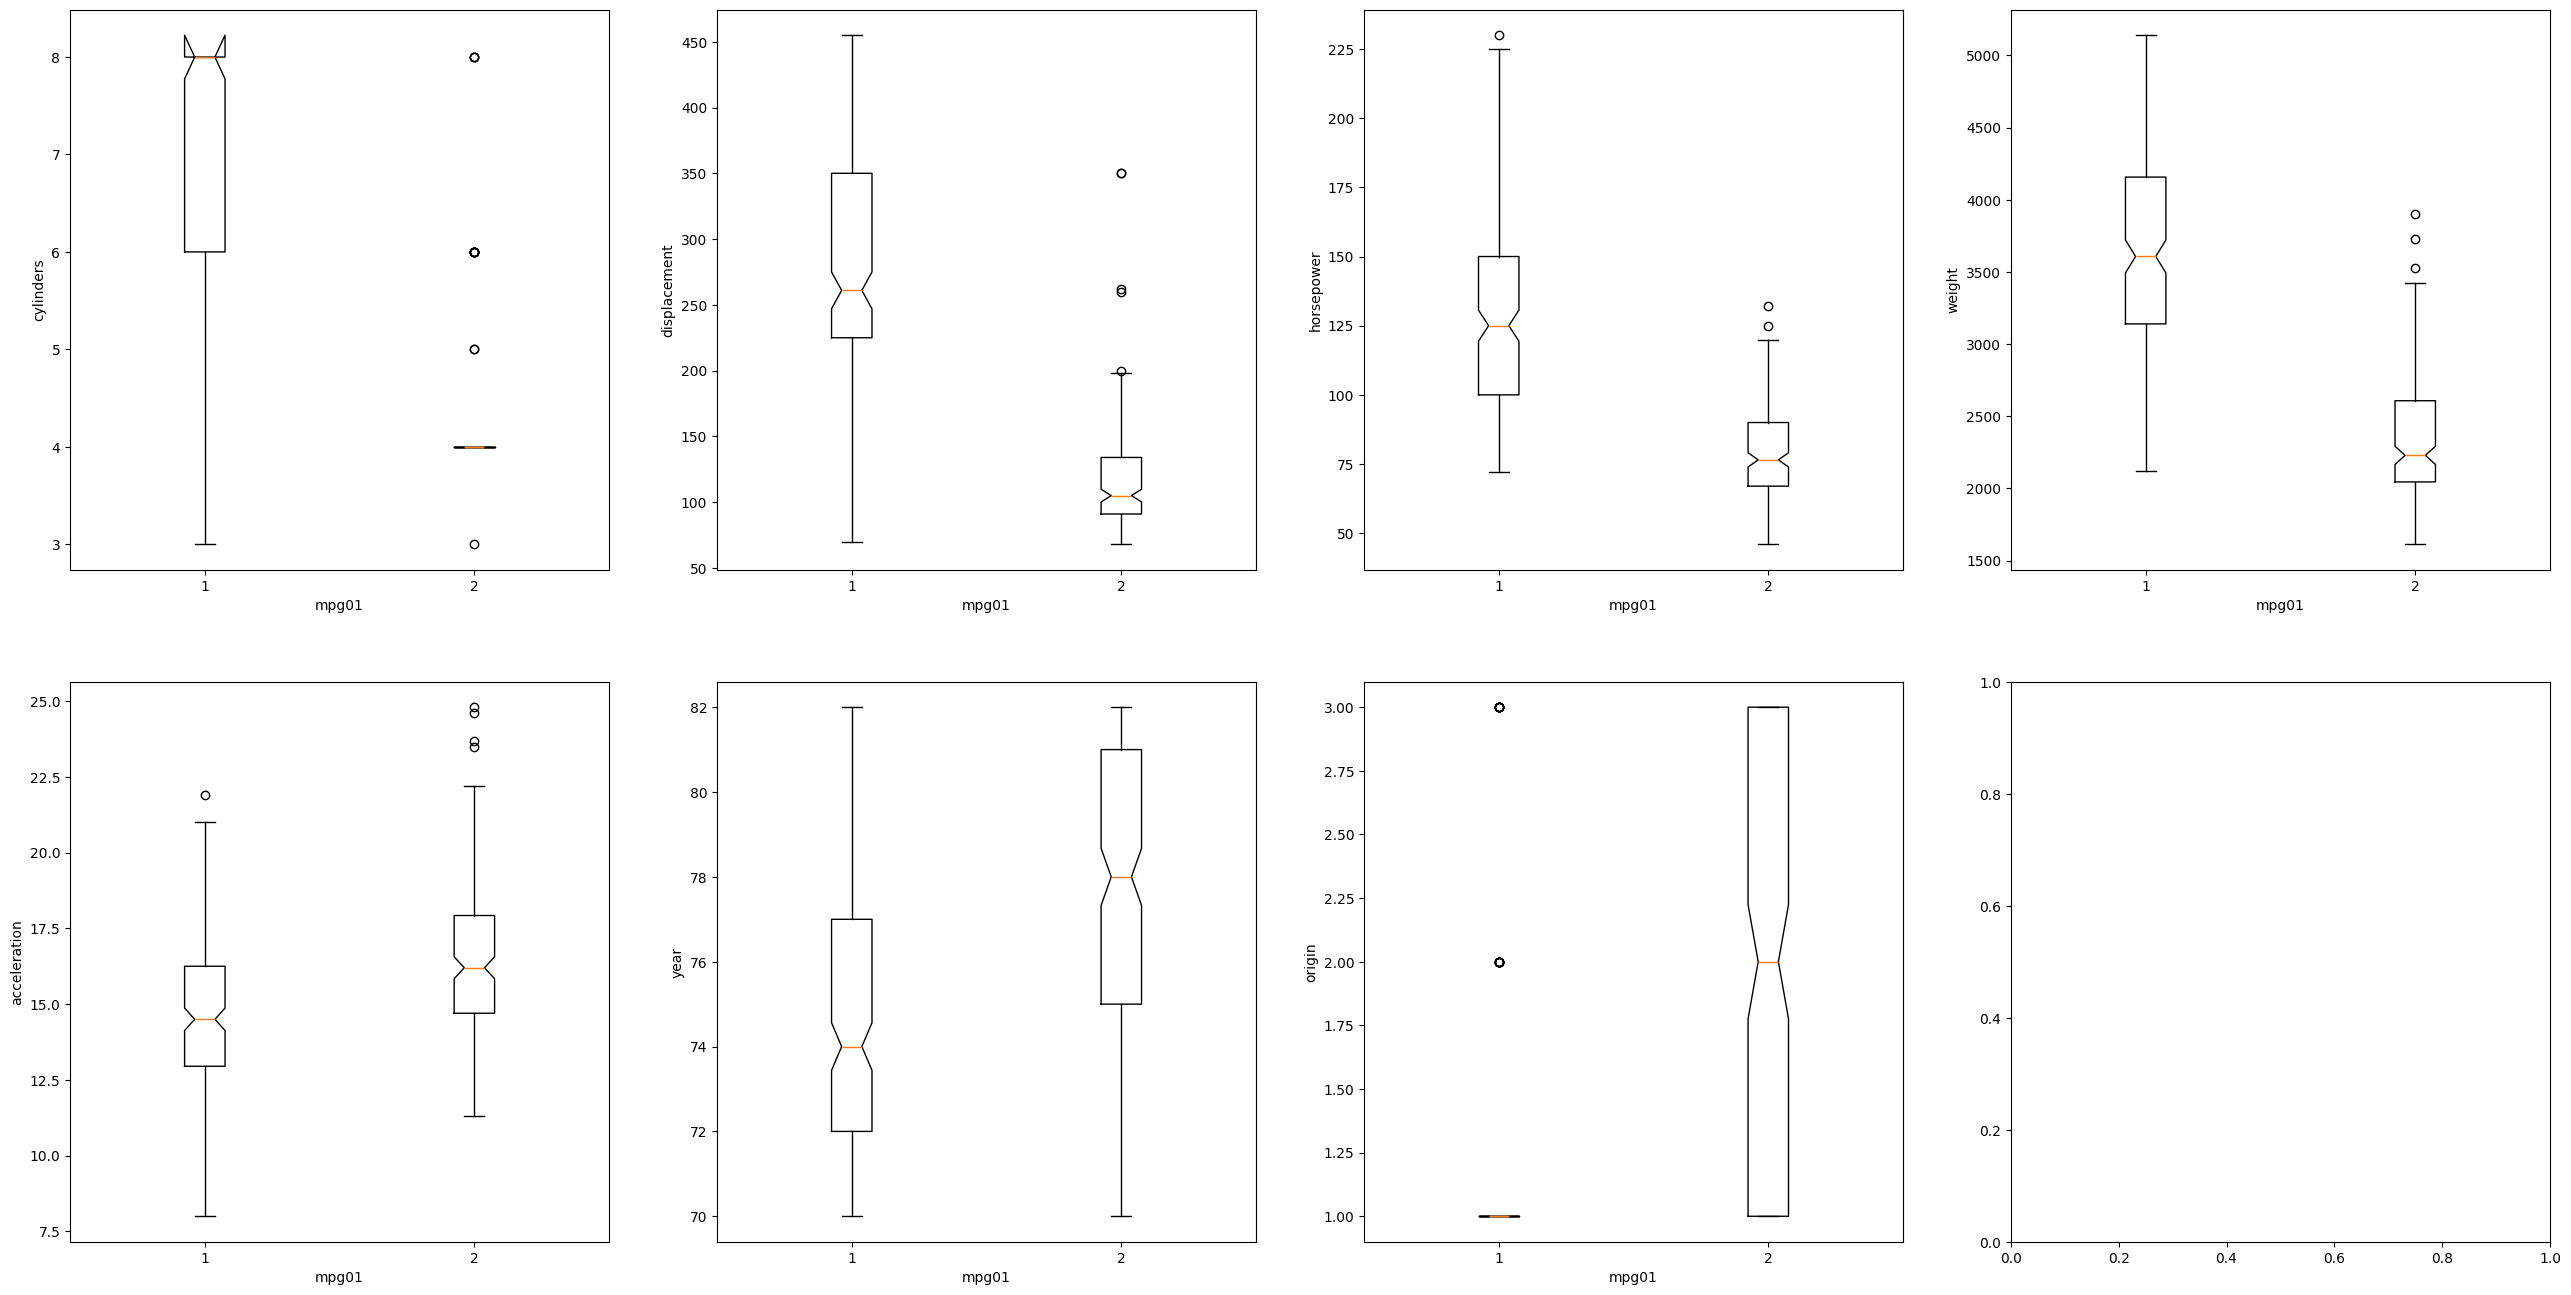

In [226]:
# (b)
fig, axes = subplots(2, 4, figsize=(32, 16))
var_list = list(Auto.columns.drop(["mpg", "mpg01"]))
for i in range(len(Auto.columns) - 2): 
    ax = axes[i//4][i%4]
    var = var_list[i]
    ax.boxplot(Auto.groupby("mpg01")[var].apply(list), 
               pd.Categorical(Auto["mpg01"]))
    ax.set_xlabel("mpg01")
    ax.set_ylabel(var)

In [227]:
# (c)
# features = Auto[["cylinders", "weight", "acceleration"]]
features = MS(["cylinders", "weight", "acceleration"]).fit_transform(Auto)
# (X_train, X_test, y_train, y_test) = train_test_split(features, 
                                                      # Auto["mpg01"],
                                                      # test_size=30,
                                                      # random_state=0)

In [228]:
# (d)
# X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
train_filter = (Auto.year < 80)
X_train = features.loc[train_filter]
X_test = features.loc[~train_filter]
y_train = Auto.mpg01.loc[train_filter]
y_test = Auto.mpg01.loc[~train_filter]

In [229]:
X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
lda = LDA(store_covariance=True)
lda.fit(X_train, y_train)
lda_pred = lda.predict(X_test)
error_rate = np.mean(lda_pred != y_test)
print("LDA test error: %.2f%%" %(error_rate * 100))

LDA test error: 12.94%


In [230]:
# (e)
qda = QDA(store_covariance=True)
qda.fit(X_train, y_train)
qda_pred = qda.predict(X_test)
error_rate = np.mean(qda_pred != y_test)
print("QDA test error: %.2f%%" %(error_rate * 100))

QDA test error: 15.29%


In [231]:
# (f)
# features = MS(["cylinders", "weight", "acceleration"]).fit_transform(Auto)
# (X_train, X_test, y_train, y_test) = train_test_split(features, 
#                                                       Auto["mpg01"],
#                                                       test_size=30,
#                                                       random_state=0)
X_train = features.loc[train_filter]
X_test = features.loc[~train_filter]
log_reg = sm.GLM(y_train, 
                 X_train, 
                 family=sm.families.Binomial())
results = log_reg.fit()
prob_list = results.predict(exog=X_test)
labels = np.array([0] * len(y_test))
labels[prob_list > .5] = 1
error_rate = np.mean(labels != y_test)
print("Log reg test error: %.2f%%" %(error_rate * 100))

Log reg test error: 20.00%


In [233]:
# (g)
# X_train, X_test = [M.drop(columns=["intercept"]) for M in [X_train, X_test]]
nb = GaussianNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
error_rate = np.mean(nb_pred != y_test)
print("NB test error: %.2f%%" %(error_rate * 100))

NB test error: 9.41%


In [236]:
# (e)
scaler = StandardScaler(with_mean=True, # whether or not to subtract the mean
                        with_std=True, # whether or not to scale the cols to have std = 1
                        copy=True) 
scaler.fit(Auto[["cylinders", "weight", "acceleration"]])
X_std = scaler.transform(Auto[["cylinders", "weight", "acceleration"]])
X_std = pd.DataFrame(X_std, 
                     index=Auto.index, 
                     columns=["cylinders", "weight", "acceleration"])

# (X_train, X_test, y_train, y_test) = train_test_split(X_std, 
#                                                       Auto["mpg01"],
#                                                       test_size=30,
#                                                       random_state=0)

X_train = X_std.loc[train_filter]
X_test = X_std.loc[~train_filter]

best_error_rate = 1
best_K = 0
for K in range(1, 41): 
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    error_rate = np.mean(y_test != knn_pred)
    if error_rate < best_error_rate: 
        best_error_rate = error_rate
        best_K = K
    # print("KNN(K=%d) test error: %.2f%%" %(K, error_rate * 100))
print("KNN(K=%d) test error: %.2f%%" %(best_K, best_error_rate * 100))

KNN(K=19) test error: 12.94%
